# App Subscription Project

by Carolina S. Lopes

**STRV DATA SCIENCE ACADEMY**

## Defining the business problem

## Data Acquisition

#### Importing libraries

We'll start our analysis by loading all necessary Python libraries in order to perform our project:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#### Loading dataset

The project's main dataset is available on the Kaggle platform. 
In order to download it, please check this [link](https://www.kaggle.com/datasets/hkhamnakhalid/customers-to-subscription-through-app-behavior).

After downloading the dataset, you need to provide the filepath in order to read it with the help of pandas library.

In [2]:
df = pd.read_csv('/Users/csergilo/Desktop/strv-ds-academy/app-subscription-strv-academy/datasets/FineTech_appData.csv')

Let's check if the dataset is consistent to what is available on Kaggle page.

In [3]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


Great! The dataset was loaded as expected. We can now proceed with the Data Wrangling workflow.

---

## Data Wrangling

The number of rows and columns of the dataframe can be checked with the `pd.DataFrame.shape` method as below, and the output is given in the format (rows, columns)

In [4]:
df.shape

(50000, 12)

The dataframe columns are listed below:

In [5]:
df.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked'],
      dtype='object')

One important step during Data Wrangling consists in checking the datatypes for each column, and confirm if they are correct. In case they aren't, we need to cast our data to the correct datatype.

In [6]:
df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

Another important step is to check whether we have any missing values on our columns:

In [7]:
df.isnull().sum()

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64

As given above, we have many missing entries in the "enrolled_date" column. This makes sense, as no date should appear in this field if the user didn't subscribe to the app Premium features.

Missing data can also appear as "0". Depending on our fields, this may affect the output of any statistical calculations for that column.

In the case of our project, a column that could present zero values that don't make sense corresponds to the "age". Or are there any babies dealing with FinTech apps already? 🤔

In [8]:
sum([value == 0 for value in df['age']])

0

Okay, that seems good! Just to be sure, let's also check if any users haven't actually interacted with the app (that is, if there's any entry where `df['numscreens']` is equal to zero).

In [9]:
sum([value == 0 for value in df['numscreens']])

0

As nothing seems suspicious with our dataset, let's check our unique values! With this step, we can infer if our columns correspond to numerical or categorical variables.

In [10]:
df.nunique()

user                    49874
first_open              49747
dayofweek                   7
hour                       24
age                        78
screen_list             38799
numscreens                151
minigame                    2
used_premium_feature        2
enrolled                    2
enrolled_date           31001
liked                       2
dtype: int64

#### Summary of all variables

**Categorical**

- **user**: unique values corresponding to user ID

- **dayofweek:** values ranging from 0 ("Monday") to 6 ("Sunday"), corresponding to the day of the week

- **hour:** time category from 00:00:00 to 23:00:00 corresponding to the *first_open* variable

- **minigame:** 
    - 0 → user didn't minigame
    - 1 → user played minigame

- **used_premium_feature:** 
    - 0 → user haven't used a Premium feature
    - 1 → Premium feature was used
        
- **liked:** 
    - 0 → user haven't liked/rated the app
    - 1 → user likes the app

**Numerical Variables**

- **age:** user ages

- **numscreens:** number of screens visited by the user

**Dates**

- **first_open:** time at which user created the account 


- **enrolled_date:** day at which user subscribed to Premium



#### Casting categorical variables

Based on the summary above and on the dtypes and unique values we encountered, let's cast some of our variables as categorical data.  

In [11]:
df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=[0, 1, 2, 3, 4, 5, 6, 7])

In [12]:
df['hour'] = df['hour'].apply(lambda value: int(value.strip()[0:2]))
df['hour'] = pd.Categorical(df['hour'], categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [13]:
# 00:00 -> 05:00 night; 06:00 -> 11:00 morning; 12:00 -> 17:00 afternoon; 18:00 -> 23:00 evening

df['dayperiod'] = df['hour'].apply(lambda value: (('night' if value >= 0 and value <= 5 else 'morning') if value <= 11 else 'afternoon') if value <= 17 else 'evening')
df['dayperiod'] = pd.Categorical(df['dayperiod'], categories=['night', 'morning', 'afternoon', 'evening'])

In [14]:
df['minigame'] = pd.Categorical(df['minigame'], categories=[0, 1])

In [15]:
df['used_premium_feature'] = pd.Categorical(df['used_premium_feature'], categories=[0, 1])

In [16]:
df['liked'] = pd.Categorical(df['liked'], categories=[0, 1])

In [17]:
df['enrolled'] = pd.Categorical(df['enrolled'], categories=[0, 1])

We can also cast the user ID as a string, so that no erroneous statistical methods are applied to this category.

In [39]:
df['user'] = df['user'].apply(str)

Our dataframe categories are now as follows:

In [40]:
df.dtypes

user                      object
first_open                object
dayofweek               category
hour                    category
age                        int64
screen_list               object
numscreens                 int64
minigame                category
used_premium_feature    category
enrolled                category
enrolled_date             object
liked                   category
dayperiod               category
dtype: object

Getting back to our dataframe, there's one column that needs special attention: the "screen_list" column. If we scroll up a bit, we can see that this column has more than 38000 unique values. That is because the entries correspond to strings with all screens that a given user has visited.

To start analysing this data, we can first turn the entries into lists with the screen names

In [19]:
df['screen_list'] = df['screen_list'].apply(lambda x: x.split(','))

And then check with how many and which unique screen names we're dealing with:

In [20]:
list_items = df['screen_list'].notnull()
all_screens = set()

for i, item in enumerate (list_items):
        
    if item == True:

            entry = df['screen_list'][i]

            for j in entry:

                # adicionar diferentes itens da coluna em um set
                all_screens.add(j)

In [23]:
total_screens = len(all_screens)
total_screens

137

In [22]:
all_screens

{'About',
 'AccountView',
 'AddProperty',
 'AddVehicle',
 'AdverseActions',
 'Alerts',
 'BVPlaidLinkContainer',
 'BVStats',
 'BankVerification',
 'BoostFriendsList',
 'CC1',
 'CC1Category',
 'CC3',
 'CameraScreen',
 'CommunityAndInvites',
 'ContactInfoConfirm',
 'Credit1',
 'Credit2',
 'Credit3',
 'Credit3Alerts',
 'Credit3CTA',
 'Credit3Container',
 'Credit3Dashboard',
 'Credits',
 'Cycle',
 'EditProfile',
 'EmploymentInfo',
 'EmploymentSummary',
 'Finances',
 'FindFriendsCycle',
 'ForgotPassword',
 'GroupedInstitutions',
 'History',
 'Home',
 'IdAndSelfieCameraScreen',
 'IdentityVerification',
 'InstantLoanSSN',
 'InstantOfferCreateAccount',
 'Institutions',
 'LLLoanAmount',
 'LandingScreen',
 'Leaderboard',
 'ListPicker',
 'Loan',
 'Loan1',
 'Loan2',
 'Loan3',
 'Loan4',
 'LoanAppAgreement',
 'LoanAppBankInfo',
 'LoanAppConfirmWithdrawal',
 'LoanAppDenied',
 'LoanAppESign',
 'LoanAppLoan4',
 'LoanAppPaymentSchedule',
 'LoanAppPromoCode',
 'LoanAppReasons',
 'LoanAppRequestAmount',
 '

From the output, we can see that there are many similar screens. For example, we can check the screens starting with "Credit":

In [25]:
[i for i in all_items if i.startswith("Credit")]

['Credit3CTA',
 'Credit3Alerts',
 'Credit3Dashboard',
 'Credit3',
 'Credits',
 'Credit2',
 'Credit3Container',
 'Credit1']

We can group these screen names in order to reduce our data. Let's define a function that will do this for us:

In [26]:
def group_screens(group):

    for i, item in enumerate(df['screen_list']):

        for j, jtem in enumerate((pd.Series(df['screen_list'][i])).str.startswith(group)):

            if jtem == True:

                df['screen_list'][i][j] = group

The function `group_screens` is able to replace all entries starting with a given string by this string. For example: if we call the function `group_screens('Credit')`, it will replace all string starting with "Credit" by "Credit".

In [ ]:
group_screens('Credit')

---

## Exploratory Data Analysis

Starting with the EDA, let's check some of the dataframe parameters:

Now that our dataset is cleaner and easier to work with, let's check the correlation between our numerical variables and our category "enrolled", which is 0 if user didn't subscribe to Premium and 1 if user subscribed to Premium.

We can start by checking some of our dataset parameters, and then define a smaller dataset derived from our main dataset:

In [41]:
df.describe()

,age,numscreens
count,50000.00000,50000.000000
mean,31.72436,21.095900
std,10.80331,15.728812
min,16.00000,1.000000
25%,24.00000,10.000000
50%,29.00000,18.000000
75%,37.00000,28.000000
max,101.00000,325.000000


In [27]:
df_num = df[['age', 'numscreens','enrolled']]

In [28]:
df_num.head()

,age,numscreens,enrolled
0,23,15,0
1,24,13,0
2,23,3,0
3,28,40,1
4,31,32,1


The method `pd.DataFrame.corr`is able to calculate the correlation between our variables. Let's plot the outcome in a heatmap:

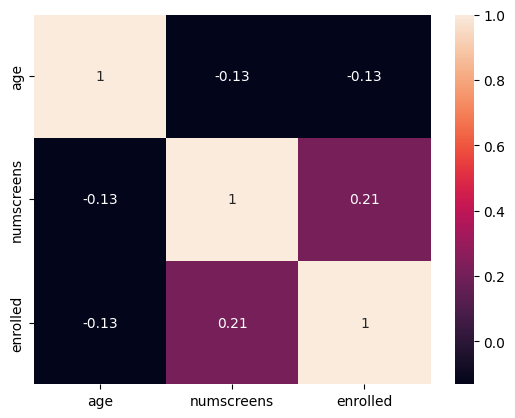

In [29]:
sns.heatmap(df_num.corr(method="pearson", numeric_only = False), annot=True);

From the plot, we can see that numscreens and age have low positive and low negative correlation with "enrolled", respectively. 

Let's check the pairplot regarding these variables:

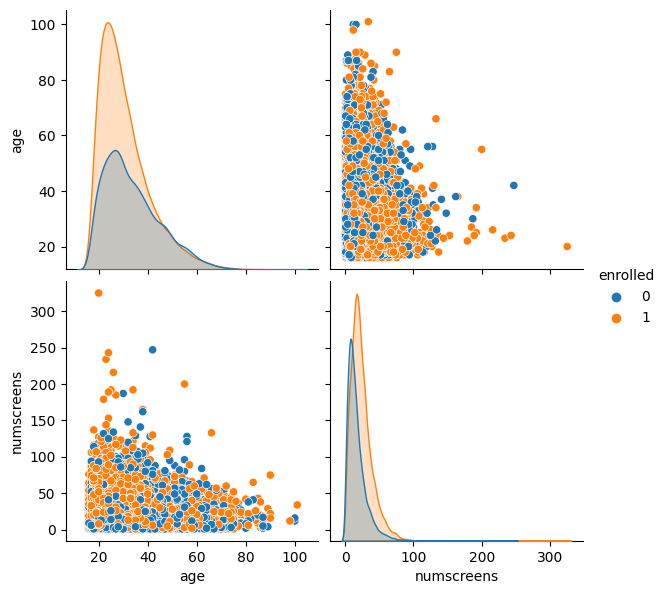

In [30]:
sns.pairplot(df_num, hue = 'enrolled', height=3);

Now, let's check the correlation between all categorical variables and label "enrolled".

The correlation between two categorical variables is calculated in a different manner compared to the correlation between a numerical and a categorical variable.

In the next steps, we'll use a function that calculates the Chi-square test of independence between two categorical variables. First, we build a cross table between two attributes using the `pd.DataFrame.crosstab` method. Next, this table is used to perform the Chi-square test.

The Chi-Square test returns an array of parameters that are used to understand the correlation between two variables in the following manner:

**Chi-square test**
    Let's consider we have an Hypothesis H0, that states that two variables are not correlated and an Hypothesis H1, which states that both are correlated. We then calculate the p-value regarding both hypotheses. If `p > 0.05`, H1 is true and H0 is rejected. If `p < 0.05`, H1 is discarded and we consider H0 as true

In [33]:
def findpValues (index, column):
    
    pValues = []
    
    for i in index:

        crosstab = pd.crosstab(index = df[i], columns = df[column])

        chi2 = chi2_contingency(crosstab)
        
        pValues.append(chi2[1])

    return pValues

In [34]:
p_Values = findpValues(['dayofweek', 'hour', 'minigame', 'used_premium_feature', 'liked', 'dayperiod'], 'enrolled')
p_Values

[5.059782268484562e-05,
 1.3933182783207918e-101,
 1.0640157293429713e-121,
 5.409192017572078e-32,
 0.1192833070298021,
 7.68255047004457e-54]

From the output, we now know that "liked" is the only attribute which is not correlated to "enrolled".








--- 


**Balanced / Imbalanced data**

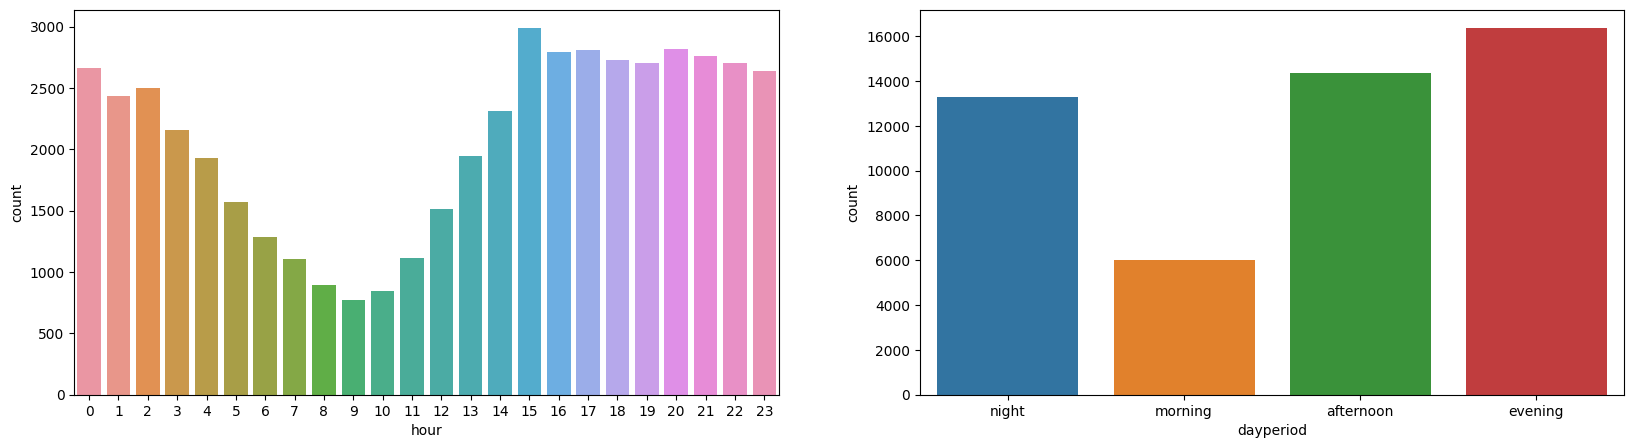

In [31]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(data=df, x='hour', ax=axes[0])
sns.countplot(data=df, x='dayperiod', ax=axes[1]);

---

# Drafts

### ML algorithms

In [ ]:
X = df[['user', 'first_open', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame', 'used_premium_feature', 'liked']]
y = df[['enrolled']]


In [ ]:
X.head()

In [ ]:
y.head()

---

In [ ]:
df_clean = pd.read_csv('/Users/csergilo/Desktop/strv-ds-academy/app-subscription-strv-academy/datasets/clean_FineTech_appData.csv')

In [ ]:
df_clean.head()

In [ ]:
sorted(df_clean.columns.tolist())

In [ ]:
df_screens = pd.read_csv('/Users/csergilo/Desktop/strv-ds-academy/app-subscription-strv-academy/datasets/top_screens.csv')

In [ ]:
df_screens.head()